# COVID-19 Survey Preprocessing and EDA

Let's do some preprocessing and exploratory data analysis (EDA) with the covid-19 data. First, import modules.

In [134]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

Read data from a .csv file into a dataframe.

In [135]:
filename = './data/1b_COVID19_daily_survey_ALL_cleaned_deid_2021-07-22_13_26.csv'
df = pd.read_csv(filename)

There are too many columns in the dataframe. Let's pick only the ones that might affect the quality and duration of sleep. Sleeptime, sleep latency and the number of wakes are target variables, since we can take them to be descriptors of sleep quality. The rest are input variables, and we want to investigate how they affect the quality and duration of sleep.

In [136]:
# Choose which columns to pick from the dataset
column_names = ['sub_id', 'sleepdiary_fallasleep', 'sleepdiary_waketime', 'steps', 'socialize_min', 'leave_house', 'people_contact',
                'alcohol_bev', 'exercise', 'stress', 'worry_scale', 'worry_finances', 'worry_health', 'PHQ9', 'PANAS_NA',
                'PANAS_PA', 'isolation', 'covid_status', 'sleepdiary_sleeplatency', 'sleepdiary_wakes']

df = df[column_names]

# Rename columns
df = df.rename(columns = {'sub_id': 'id', 'steps': 'Steps', 'socialize_min': 'Socialize (min)', 'leave_house': 'Leave house',
                          'people_contact': 'People contact', 'alcohol_bev': 'Alcohol (bev)', 'exercise': 'Exercise',
                          'stress': 'Stress', 'worry_scale': 'Worry (scale)', 'worry_finances': 'Worry (finances)',
                          'worry_health': 'Worry (health)', 'PANAS_NA': 'PANAS (NA)', 'PANAS_PA': 'PANAS (PA)',
                          'isolation': 'Isolation', 'covid_status': 'Covid-19', 'sleepdiary_wakes': 'Wakes',
                          'sleepdiary_sleeplatency': 'Latency'})

As a first step, we compute the total sleep time in hours for each row. This is not simple, since the timestamps don't include dates. This leaves room for interpertation and assumptions have to be made. We assume the following: time slept should not be negative or more than 22 hours and the earliest time anyone would go sleep is 17:00. If we don't get a sensible sleep time with these conditions, we set is to NaN.

In [137]:
fallasleep = df['sleepdiary_fallasleep'].tolist()
waketime = df['sleepdiary_waketime'].tolist()
latency = df['Latency'].tolist()
sleeptime = []

def compute_sleeptime(fallasleep, waketime, latencymins):
    try:
        sleep_day = 1
        sleep_hour = int(fallasleep[0:2])
        sleep_min = int(fallasleep[3:5]) + int(latencymins)
        wake_hour = int(waketime[0:2])
        wake_min = int(waketime[3:5])

        tmp = sleep_min // 60
        sleep_hour += tmp
        tmp = sleep_hour // 24
        sleep_day += tmp
        tmp = sleep_hour % 24
        sleep_hour = tmp
        tmp = sleep_min % 60
        sleep_min = tmp

        if sleep_hour <= 17:
            sleep_day += 1

        time_i = datetime(2000, 1, sleep_day, sleep_hour, sleep_min)
        time_f = datetime(2000, 1, 2, wake_hour, wake_min)

    except:
        return np.NaN

    delta = time_f - time_i
    delta_hours = delta.total_seconds()/(60**2)

    if delta_hours < 0 or delta_hours > 22:
        return np.NaN
    else:
        return delta_hours

for i in range(len(fallasleep)):
    delta_hours = compute_sleeptime(fallasleep[i], waketime[i], latency[i])
    sleeptime.append(delta_hours)

# Add sleep time to dataframe
df['Sleeptime (h)'] = sleeptime
# Drop unnecessary columns
df = df.drop(['sleepdiary_fallasleep', 'sleepdiary_waketime'], axis = 1)

We also only keep rows with negative Covid status and drop all rows containing NaNs. There are multiple entries from the same people in the dataset. Let's group the data by individula IDs and take the mean of the rows for each participant.

In [138]:
# Choose only rows with negative covid status
df = df[df['Covid-19'] == 0]
# Drop unecessary column
df = df.drop(['Covid-19'], axis = 1)
# Drop rows containing NaNs
df = df.dropna()

# Gather unique IDs and group by those
df = df.groupby('id').mean()
df.describe()

,Steps,Socialize (min),Leave house,People contact,Alcohol (bev),Exercise,Stress,Worry (scale),Worry (finances),Worry (health),PHQ9,PANAS (NA),PANAS (PA),Isolation,Latency,Wakes,Sleeptime (h)
count,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000
mean,6483.118138,44.934810,0.732834,5.800910,0.735266,0.549757,3.901622,18.818659,3.839588,4.675466,6.380912,16.625206,22.776775,4.263561,17.631330,1.350687,7.794283
std,4467.689936,53.791041,0.308813,29.087008,1.032864,0.356249,1.239892,5.397607,1.459809,1.381332,4.462773,5.510401,7.758652,1.340094,15.974337,1.033583,1.162888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,1.000000,1.000000,0.000000,10.000000,10.000000,1.000000,0.000000,0.000000,2.333333
25%,3323.892857,12.146465,0.555556,0.600000,0.000000,0.250000,3.000000,15.000000,2.818182,3.600000,3.000000,12.395455,17.146774,3.200000,7.862554,0.600000,7.205208
50%,5707.654125,30.000000,0.833333,1.807114,0.335271,0.568323,3.790244,18.436508,3.763889,4.814496,5.644958,15.333333,21.000000,4.203448,13.500000,1.062745,7.826389
75%,8759.221429,60.000000,1.000000,4.411932,1.000000,0.899359,4.817340,22.083807,5.000000,5.800000,9.000000,19.666667,27.286378,5.281538,21.331044,2.000000,8.390865
max,33098.000000,676.960000,1.000000,703.757576,7.000000,1.000000,7.000000,35.000000,7.000000,7.000000,24.000000,44.000000,49.416667,7.000000,120.000000,5.000000,20.000000


Plot a correlation table, where we can see the correlations between any two variables.

<Axes: >

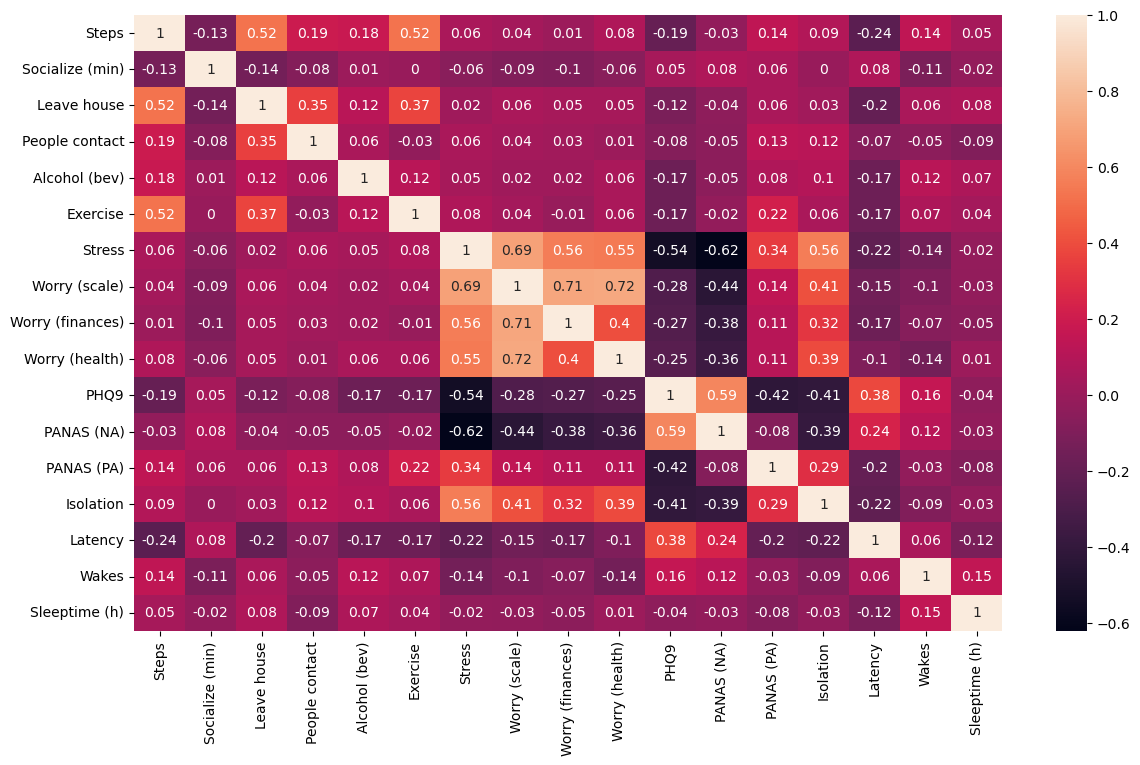

In [139]:
corr = df.corr(method = 'spearman').round(2)
plt.figure(figsize = (14, 8))
sns.heatmap(corr, annot = True)

Plot histograms of variable distributions to see their distributions.

<Axes: title={'center': 'Sleep time'}, xlabel='Sleeptime (h)', ylabel='Count'>

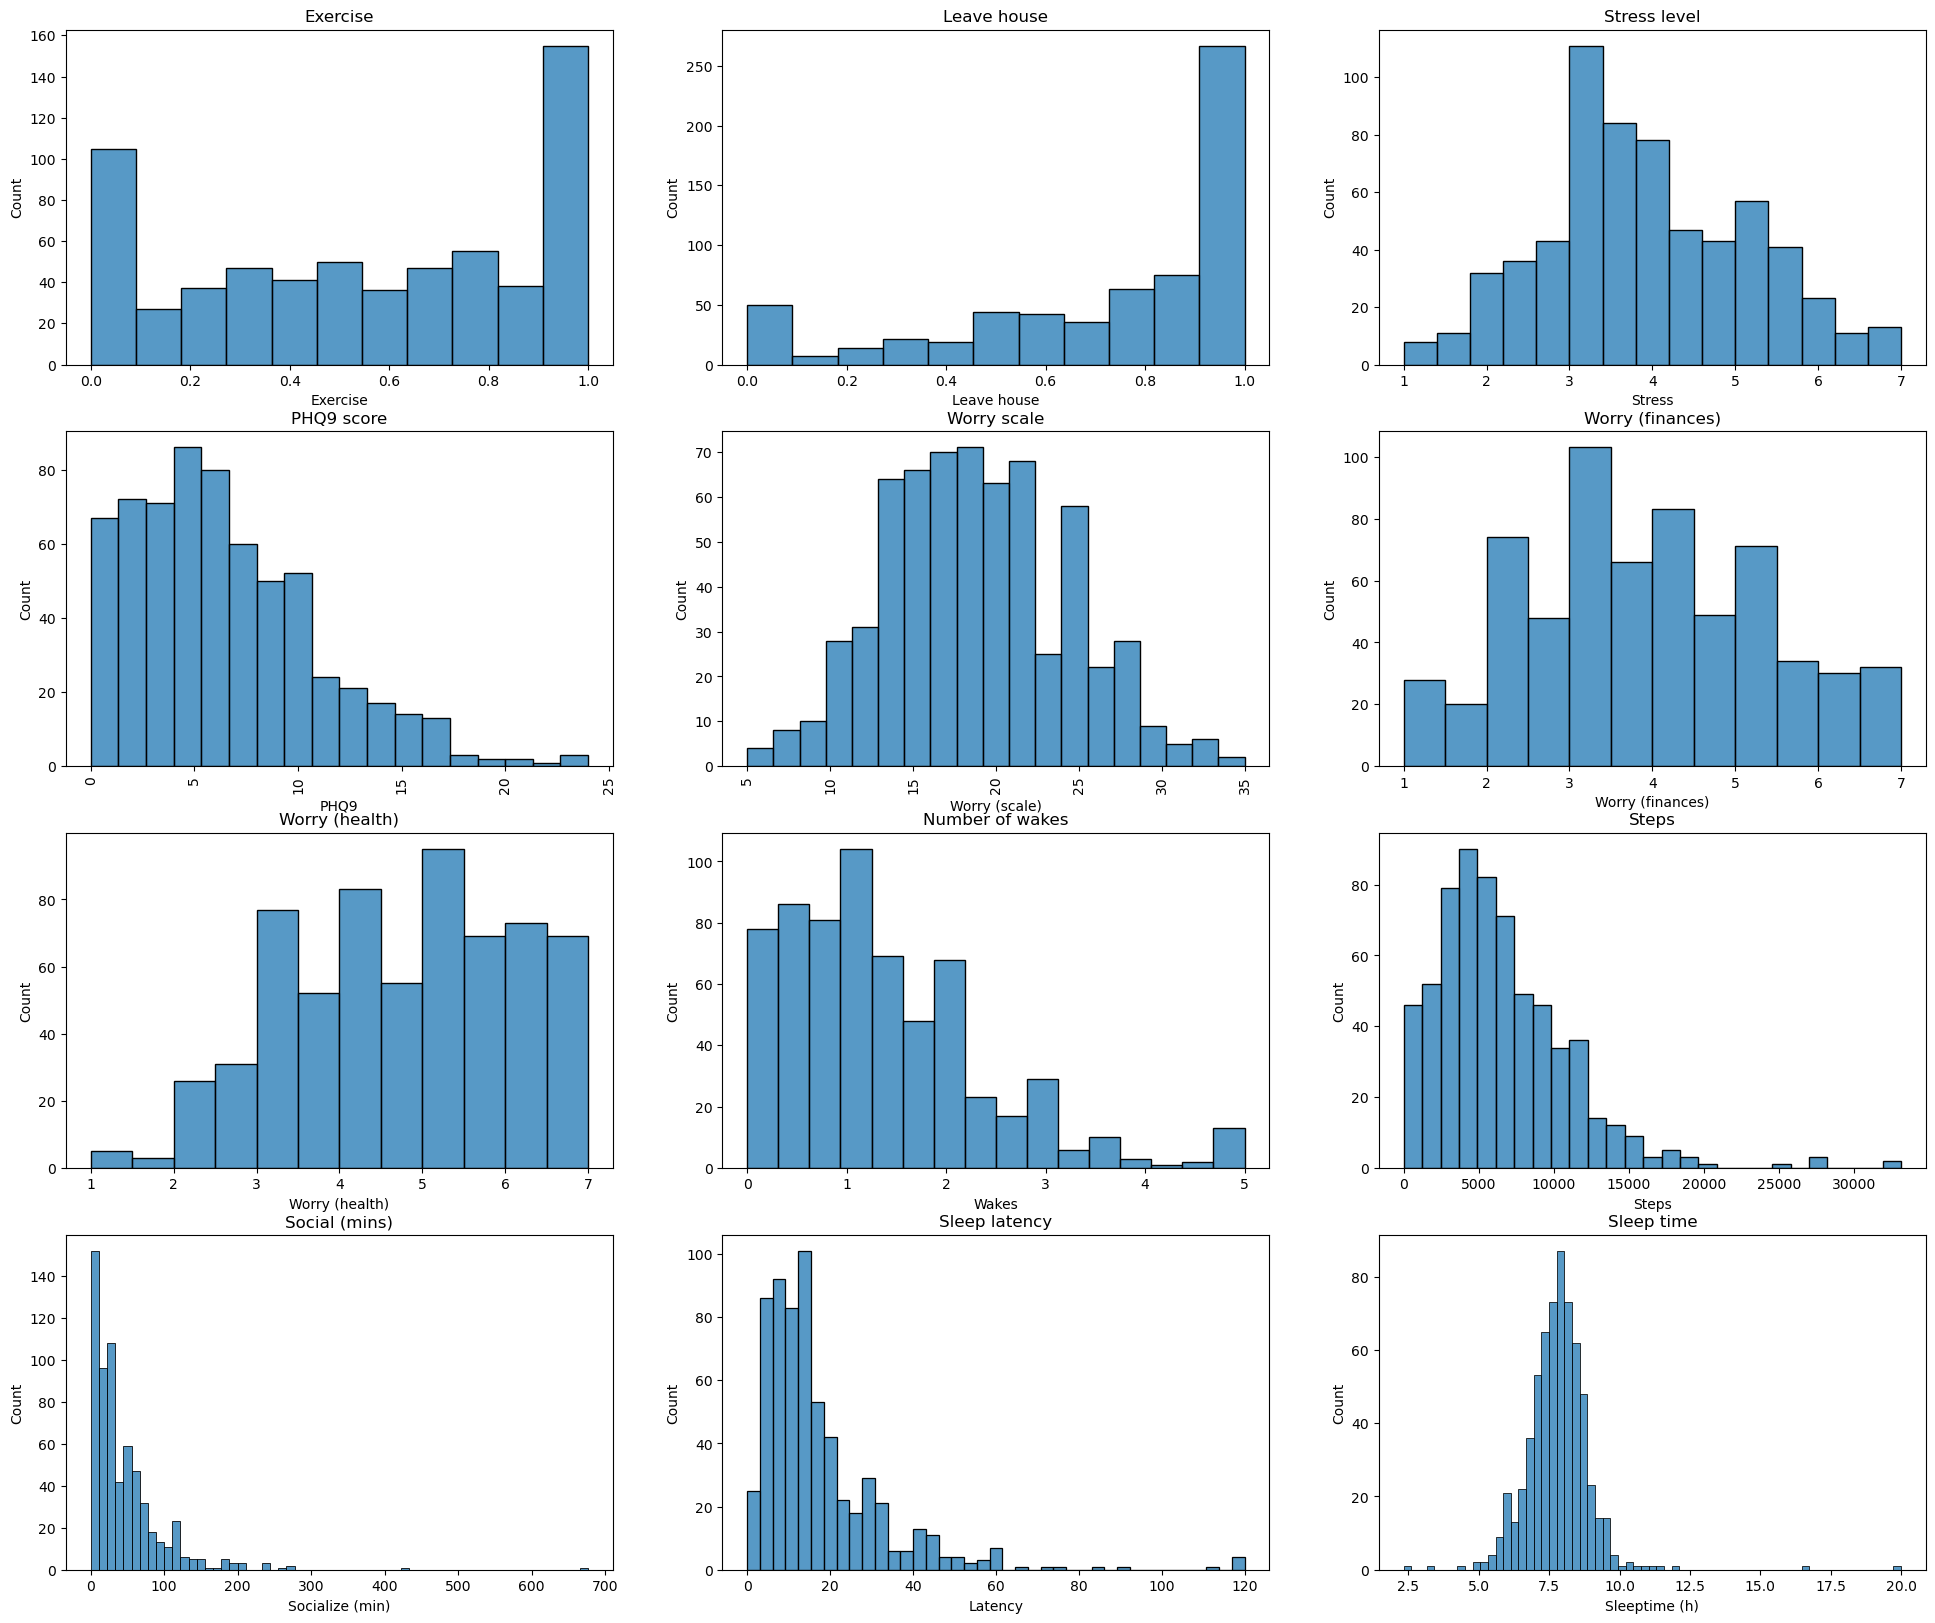

In [140]:
plt.figure(figsize = (24, 20))

rows = 4
columns = 3

plt.subplot(rows, columns, 1)
plt.gca().set_title('Exercise')
sns.histplot(x = 'Exercise', data = df)

plt.subplot(rows, columns, 2)
plt.gca().set_title('Leave house')
sns.histplot(x = 'Leave house', data = df)

plt.subplot(rows, columns, 3)
plt.gca().set_title('Stress level')
sns.histplot(x = 'Stress', data = df)

plt.subplot(rows, columns, 4)
plt.gca().set_title('PHQ9 score')
plt.xticks(rotation = 90)
sns.histplot(x = 'PHQ9', data = df)

plt.subplot(rows, columns, 5)
plt.gca().set_title('Worry scale')
plt.xticks(rotation = 90)
sns.histplot(x = 'Worry (scale)', data = df)

plt.subplot(rows, columns, 6)
plt.gca().set_title('Worry (finances)')
sns.histplot(x = 'Worry (finances)', data = df)

plt.subplot(rows, columns, 7)
plt.gca().set_title('Worry (health)')
sns.histplot(x = 'Worry (health)', data = df)

plt.subplot(rows, columns, 8)
plt.gca().set_title('Number of wakes')
sns.histplot(x = 'Wakes', data = df)

plt.subplot(rows, columns, 9)
plt.gca().set_title('Steps')
sns.histplot(x = df['Steps'], kde = False)

plt.subplot(rows, columns, 10)
plt.gca().set_title('Social (mins)')
sns.histplot(x = df['Socialize (min)'], kde = False)

plt.subplot(rows, columns, 11)
plt.gca().set_title('Sleep latency')
sns.histplot(x = df['Latency'], kde = False)

plt.subplot(rows, columns, 12)
plt.gca().set_title('Sleep time')
sns.histplot(x = df['Sleeptime (h)'], kde = False)

Let's plot some scatter plots showing the relations between sleeptime and other variables.

<Axes: title={'center': 'Number of Wakes'}, xlabel='Wakes', ylabel='Sleeptime (h)'>

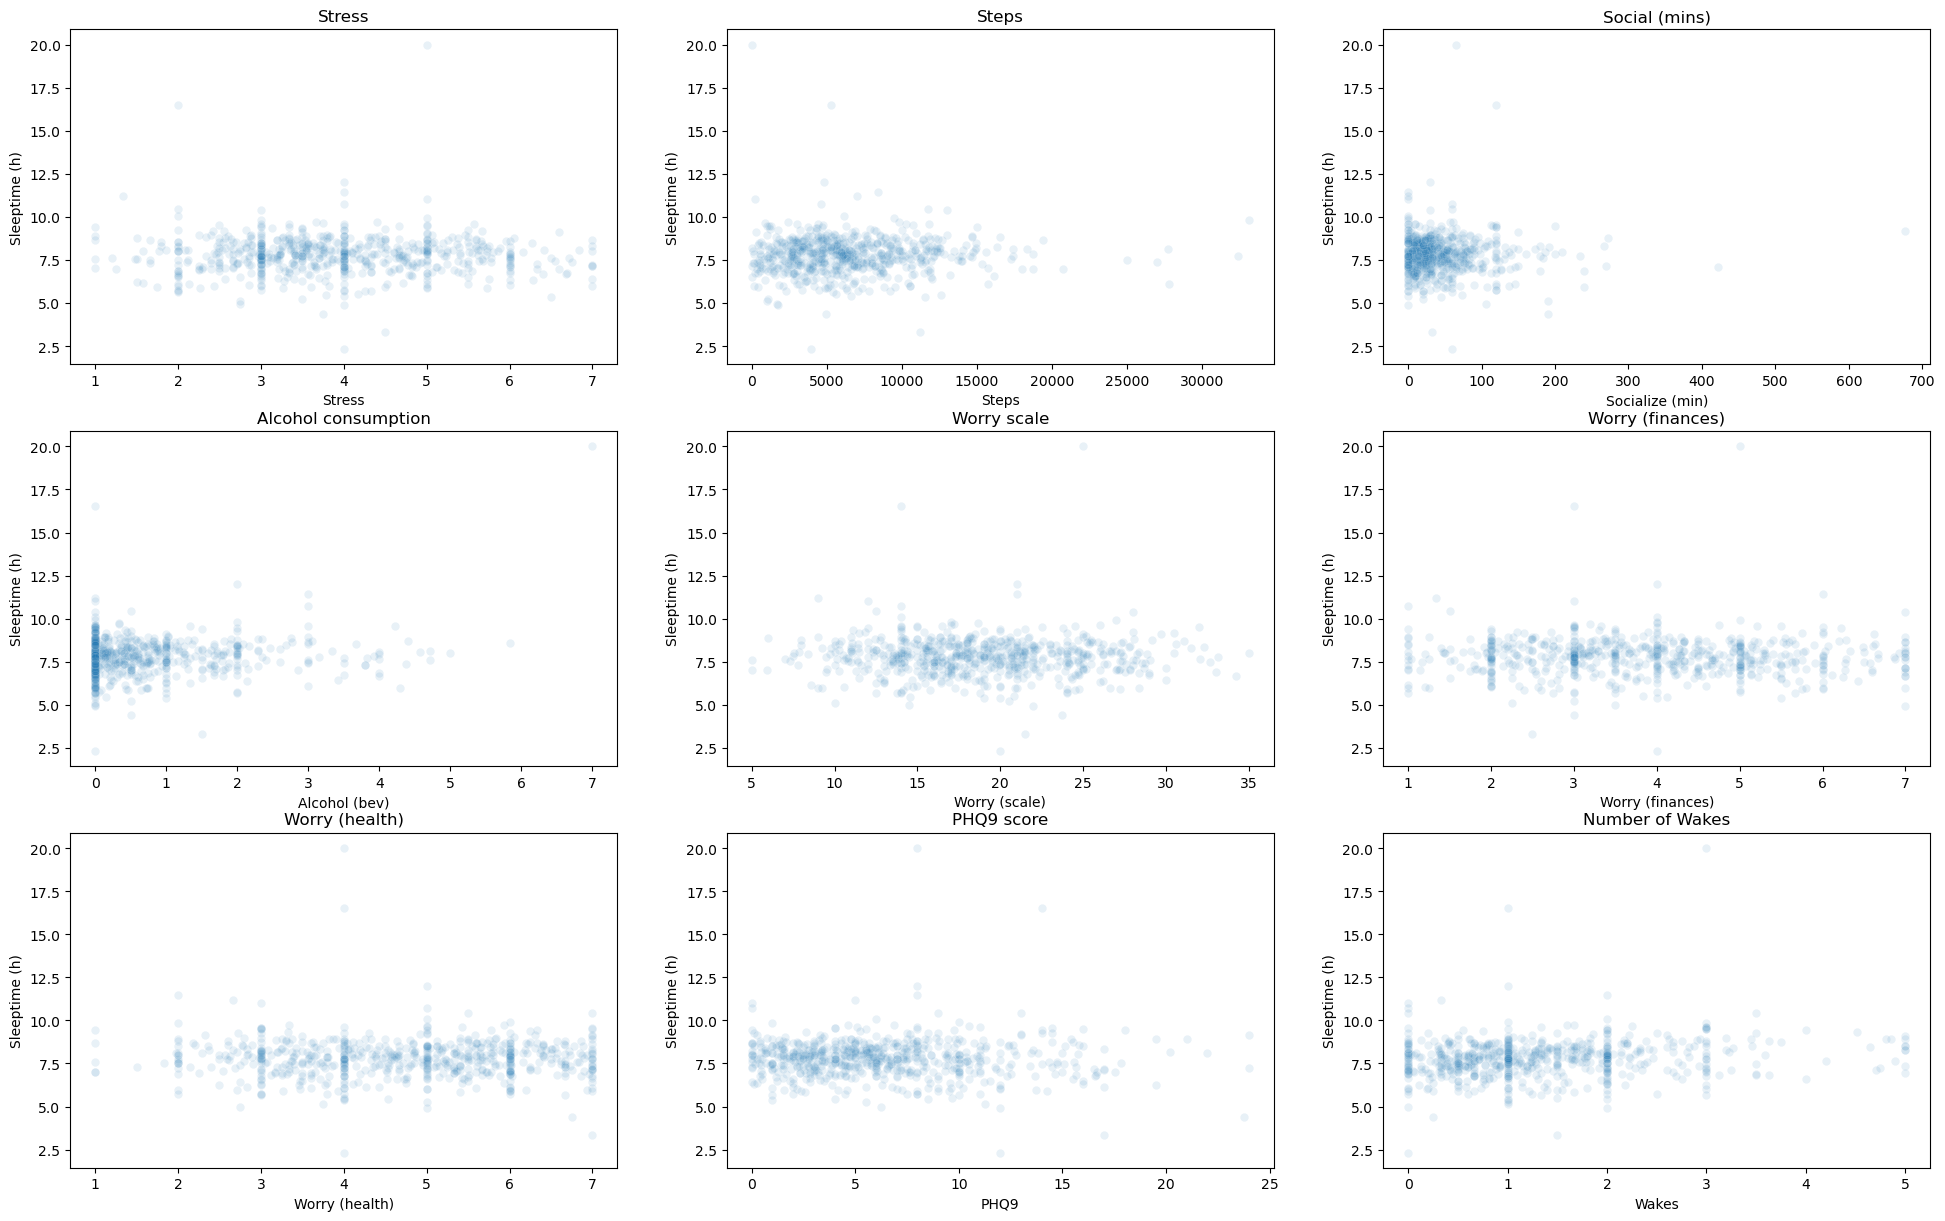

In [141]:
plt.figure(figsize = (24, 20))

rows = 4
columns = 3
alpha = 0.1

plt.subplot(rows, columns, 1)
plt.gca().set_title('Stress')
sns.scatterplot(x = df['Stress'], y = df['Sleeptime (h)'], alpha = alpha)

plt.subplot(rows, columns, 2)
plt.gca().set_title('Steps')
sns.scatterplot(x = df['Steps'], y = df['Sleeptime (h)'], alpha = alpha)

plt.subplot(rows, columns, 3)
plt.gca().set_title('Social (mins)')
sns.scatterplot(x = df['Socialize (min)'], y = df['Sleeptime (h)'], alpha = alpha)

plt.subplot(rows, columns, 4)
plt.gca().set_title('Alcohol consumption')
sns.scatterplot(x = df['Alcohol (bev)'], y = df['Sleeptime (h)'], alpha = alpha)

plt.subplot(rows, columns, 5)
plt.gca().set_title('Worry scale')
sns.scatterplot(x = df['Worry (scale)'], y = df['Sleeptime (h)'], alpha = alpha)

plt.subplot(rows, columns, 6)
plt.gca().set_title('Worry (finances)')
sns.scatterplot(x = df['Worry (finances)'], y = df['Sleeptime (h)'], alpha = alpha)

plt.subplot(rows, columns, 7)
plt.gca().set_title('Worry (health)')
sns.scatterplot(x = df['Worry (health)'], y = df['Sleeptime (h)'], alpha = alpha)

plt.subplot(rows, columns, 8)
plt.gca().set_title('PHQ9 score')
sns.scatterplot(x = df['PHQ9'], y = df['Sleeptime (h)'], alpha = alpha)

plt.subplot(rows, columns, 9)
plt.gca().set_title('Number of Wakes')
sns.scatterplot(x = df['Wakes'], y = df['Sleeptime (h)'], alpha = alpha)

Similar plots showing the relationships between sleep latency and other variables.

<Axes: title={'center': 'Number of Wakes'}, xlabel='Wakes', ylabel='Latency'>

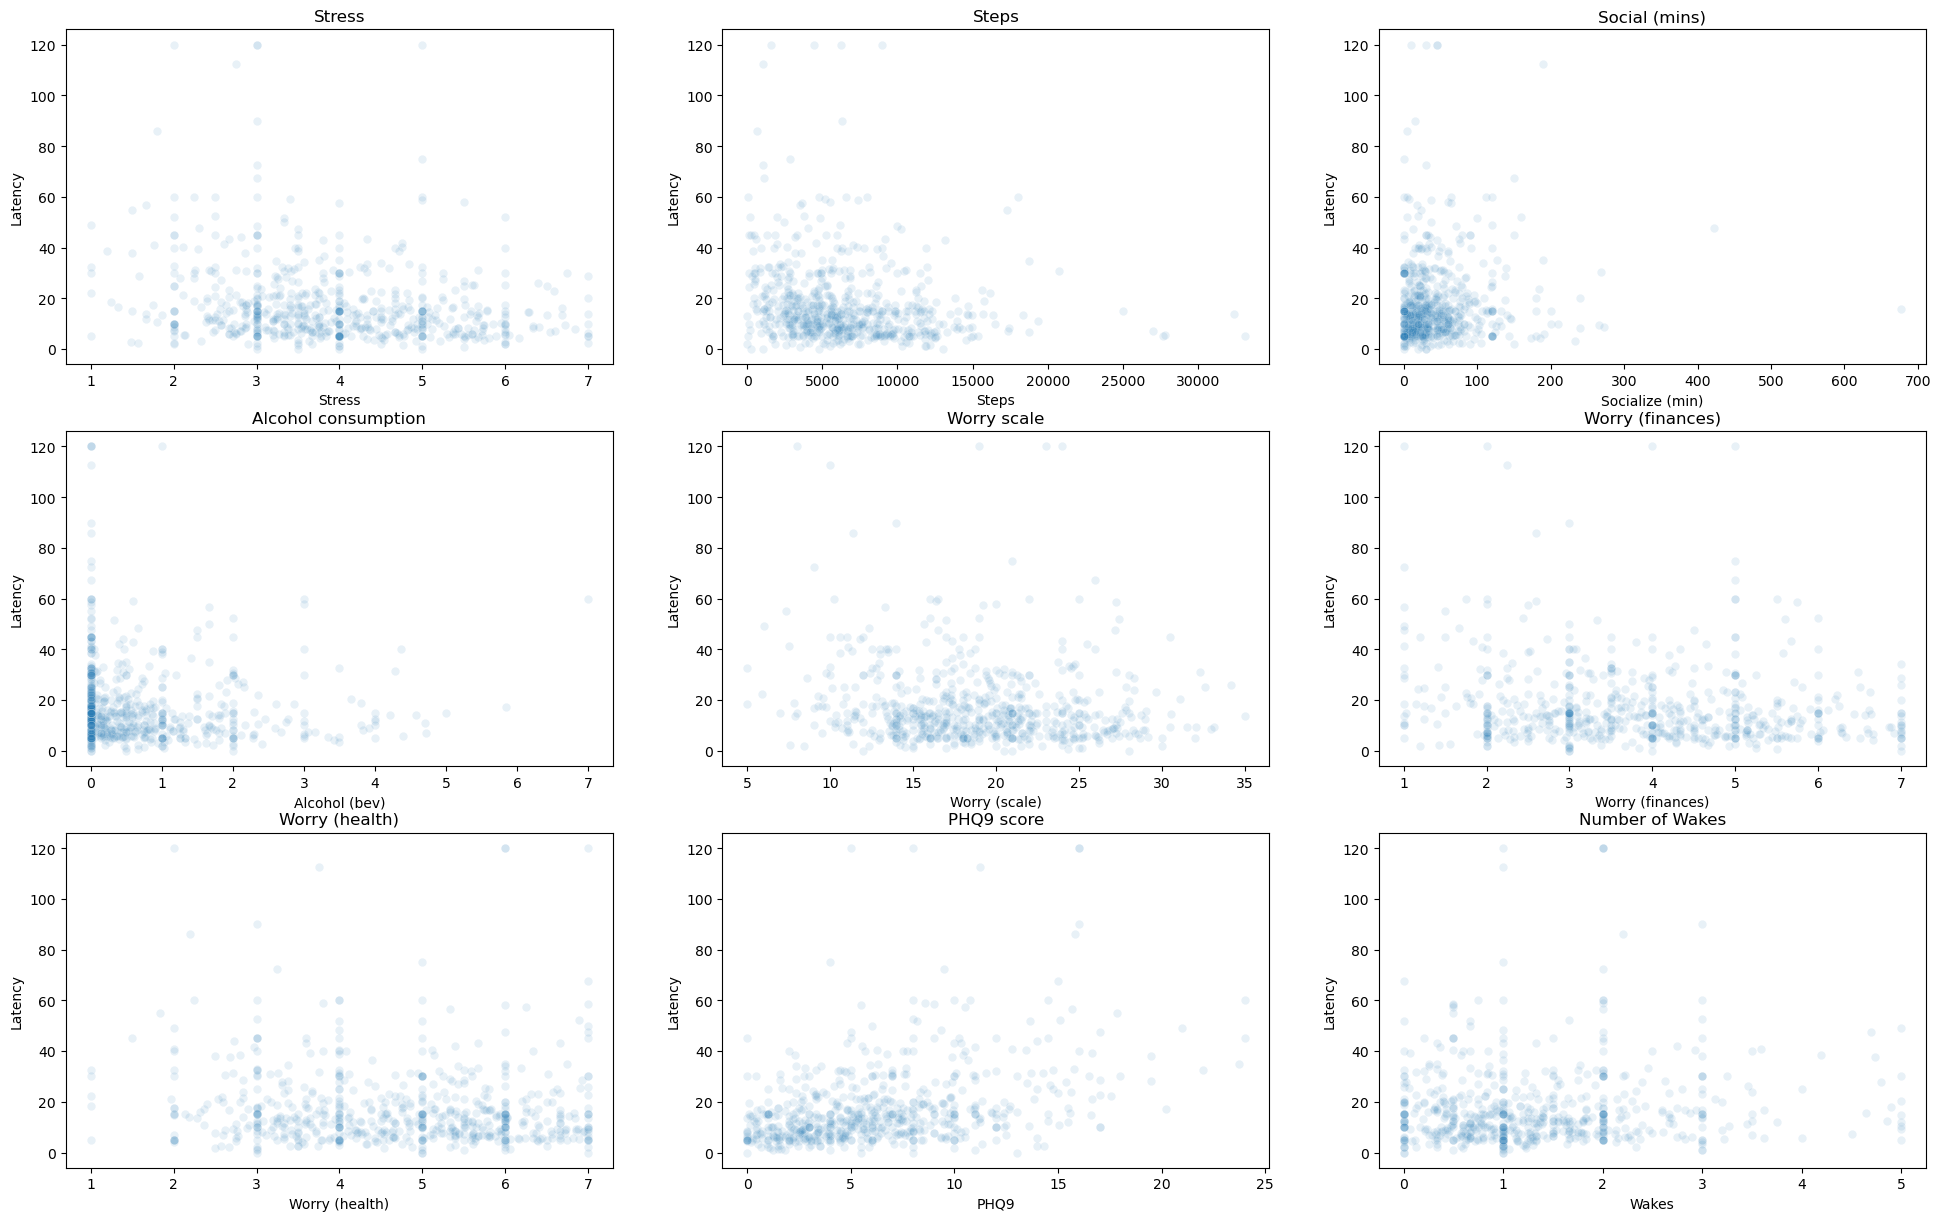

In [142]:
plt.figure(figsize = (24, 20))

rows = 4
columns = 3
alpha = 0.1

plt.subplot(rows, columns, 1)
plt.gca().set_title('Stress')
sns.scatterplot(x = df['Stress'], y = df['Latency'], alpha = alpha)

plt.subplot(rows, columns, 2)
plt.gca().set_title('Steps')
sns.scatterplot(x = df['Steps'], y = df['Latency'], alpha = alpha)

plt.subplot(rows, columns, 3)
plt.gca().set_title('Social (mins)')
sns.scatterplot(x = df['Socialize (min)'], y = df['Latency'], alpha = alpha)

plt.subplot(rows, columns, 4)
plt.gca().set_title('Alcohol consumption')
sns.scatterplot(x = df['Alcohol (bev)'], y = df['Latency'], alpha = alpha)

plt.subplot(rows, columns, 5)
plt.gca().set_title('Worry scale')
sns.scatterplot(x = df['Worry (scale)'], y = df['Latency'], alpha = alpha)

plt.subplot(rows, columns, 6)
plt.gca().set_title('Worry (finances)')
sns.scatterplot(x = df['Worry (finances)'], y = df['Latency'], alpha = alpha)

plt.subplot(rows, columns, 7)
plt.gca().set_title('Worry (health)')
sns.scatterplot(x = df['Worry (health)'], y = df['Latency'], alpha = alpha)

plt.subplot(rows, columns, 8)
plt.gca().set_title('PHQ9 score')
sns.scatterplot(x = df['PHQ9'], y = df['Latency'], alpha = alpha)

plt.subplot(rows, columns, 9)
plt.gca().set_title('Number of Wakes')
sns.scatterplot(x = df['Wakes'], y = df['Latency'], alpha = alpha)

As an example, let's see how stress affects the number of wakes. In the figure below, the number in each box is the number of rows with the corresponding values of wakes and stress.

In [143]:
#counts_array = []
#
#for stress_level in [1, 2, 3, 4, 5, 6, 7]:
#    counts = df[df['Stress'] == stress_level]['Wakes'].value_counts().tolist()
#    counts_array.append(counts)

#df_tmp = pd.DataFrame(counts_array, columns = ['0', '1', '2', '3', '4', '5'])
#df_tmp.index = np.arange(1, len(df_tmp) + 1)
#df_tmp = df_tmp.rename_axis('Stress')
#df_tmp = df_tmp.rename_axis('Wakes', axis = 1)

#f, ax = plt.subplots(figsize = (9, 6))
#sns.heatmap(df_tmp, annot = True, fmt = "d", linewidths = 0.5, ax = ax, cmap = 'crest')

Finally, save the preprocessed data to a .csv file.

In [144]:
filename = './data/covid_data_preprocessed.csv'

df.to_csv(filename)